In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
from sklearn import model_selection,svm,metrics,linear_model
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

I've downloaded 2,872 csv files. This corresponds to 359 patients * 8 tubes. I know from the documentation that each tube contains 30,000 cells with 7 different per tube. Also that the 8th tube represents an "iso" or negative control tube (no useful information). Take a peek..

In [4]:
pd.options.display.max_rows = 10
pd.read_csv('C:\\python27\\FCS\\1.csv').head()

,FS Lin:FS Lin,SS Log:SS Log,FL1 Log:IgG1-FITC,FL2 Log:IgG1-PE,FL3 Log:CD45-ECD,FL4 Log:IgG1-PC5,FL5 Log:IgG1-PC7
0,85.4,3.807259,0.102400,0.391139,38.763676,0.174088,0.102400
1,204.6,27.541492,0.677037,0.570681,16.793596,0.148066,0.242829
2,183.4,20.284998,0.596932,0.747448,18.209581,0.347977,0.624390
3,178.0,20.284998,0.570681,0.268083,15.349040,0.102400,0.102400
4,171.0,29.331293,0.560507,0.570681,8.177936,0.201034,0.118250
...,...,...,...,...,...,...,...
29995,95.2,2.494702,0.102400,0.102400,58.628998,0.102400,0.102400
29996,80.4,2.804142,0.102400,0.102400,48.537926,0.102400,0.416557
29997,77.6,1.837411,0.134118,0.318044,33.267387,0.102400,0.102400
29998,94.6,3.841658,0.102400,0.102400,58.628998,0.405468,0.110040


What's the range for each marker? First, it will be useful to put all tubes into one file each so we only have to open 1 file per patient.

In [ ]:
for i in range(1,2873):    
    if i%8 == 1: # first tube
        temp = pd.read_csv('C:\\python27\\FCS\\'+str(i)+'.csv').ix[:6999,2:]
        
    elif i%8 > 1: # concat the next tube. for i = 7, concat tube 8.
        temp = pd.concat([temp,pd.read_csv('C:\\python27\\FCS\\'+str(i)+'.csv').ix[:6999,2:]],axis=1)
        
    elif i%8 == 0: # tube 8 for every patient: write the set of 8 into a new csv named for patient number
        temp = pd.concat([temp,pd.read_csv('C:\\python27\\FCS\\'+str(i)+'.csv').ix[:6999,2:]],axis=1)
        topath = 'C:\\python27\\FCS2\\'+str(i/8)+'.csv'
        temp.to_csv(topath)

Now iterate through the 359 files and find the max values.

In [10]:
maxsig = np.zeros(56)

for i in range(1,360):
    temp = pd.read_csv('C:\\python27\\FCS2\\'+str(i)+'.csv', index_col = 0)
    for j in range(0,len(temp.columns)):
        if temp[temp.columns[j]].max() > maxsig[j]:
            maxsig[j] = temp[temp.columns[j]].max() 
            
maxsig

array([  204.6    ,  1014.83093,  1014.83093,   970.20264,  1005.744  ,
        1005.744  ,  1014.83093,   204.6    ,  1014.83093,  1014.83093,
        1014.83093,   978.96844,   911.0007 ,   952.90576,   204.6    ,
        1014.83093,  1014.83093,   944.3733 ,   987.8135 ,   894.7593 ,
         902.84344,   204.6    ,  1014.83093,  1014.83093,  1014.83093,
         996.73846,   996.73846,  1014.83093,   204.6    ,  1014.83093,
        1005.744  ,   970.20264,  1005.744  ,   911.0007 ,  1005.744  ,
         204.6    ,  1014.83093,  1014.83093,   978.96844,   996.73846,
        1005.744  ,  1005.744  ,   204.6    ,  1014.83093,  1014.83093,
         832.63794,  1005.744  ,   996.73846,   987.8135 ,   204.6    ,
        1014.83093,  1005.744  ,   894.7593 ,  1014.83093,   927.5369 ,
         952.90576])

Appears the first marker of every tube maxes at 204.6 and all others at 1014.83093. 

Let's look at some plots. Patient 1, first two markers plotted against each other. (This is what pathologists do, for several dozen marker combinations.)

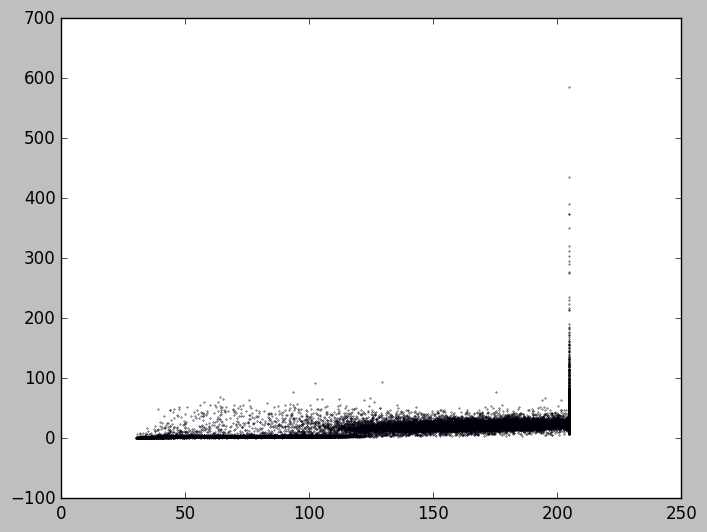

In [19]:
data = np.genfromtxt('C:\\python27\\FCS\\1.csv',delimiter=',',usecols=(0,1),skip_header=1)
plt.scatter(data[:,0],data[:,1], s=.1)

#plt.xlim(0,220)
#plt.ylim(0,50)

Pretty hard to see anything. There's that tail on the right that I doubt contains any useful information. Let's cut it off.

(0, 50)

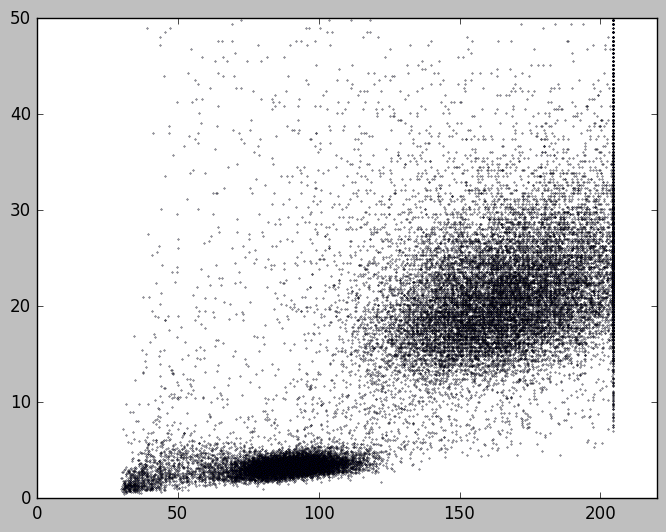

In [20]:
data = np.genfromtxt('C:\\python27\\FCS\\1.csv',delimiter=',',usecols=(0,1),skip_header=1)
plt.scatter(data[:,0],data[:,1], s=.1)
plt.xlim(0,220)
plt.ylim(0,50)

There's a ton of data squashed at the bottom. We should apply a log 10 transformation to spread things out.

(0, 2)

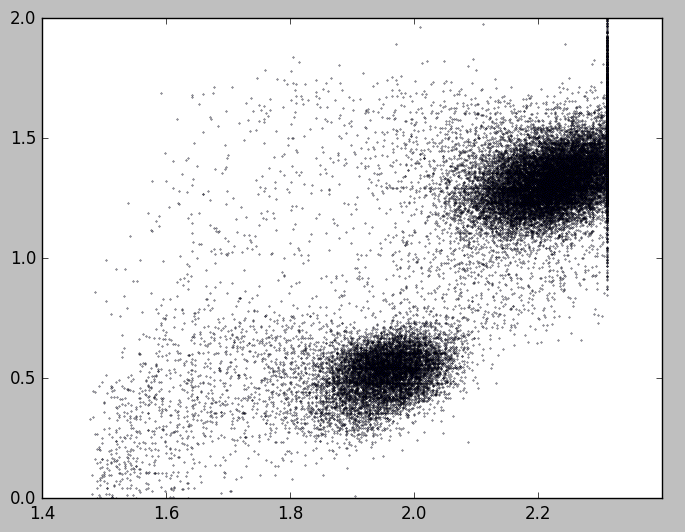

In [23]:
data = np.genfromtxt('C:\\python27\\FCS\\1.csv',delimiter=',',usecols=(0),skip_header=1)
data2 = np.genfromtxt('C:\\python27\\FCS\\1.csv',delimiter=',',usecols=(1),skip_header=1)
plt.scatter(np.log10(data),np.log10(data2), s=.1)
plt.xlim(1.4,2.4)
plt.ylim(0,2)

Looks much better, and if we even compare it to patient 9 who is leukemic, we can visually tell a difference.

(0, 2)

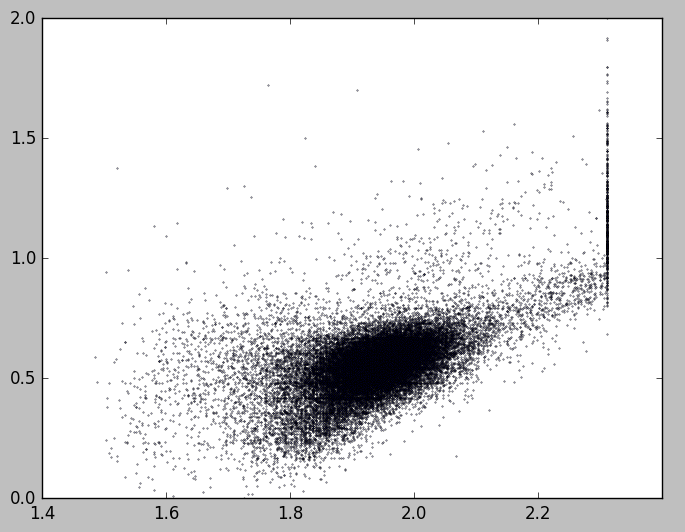

In [25]:
data = np.genfromtxt('C:\\python27\\FCS\\65.csv',delimiter=',',usecols=(0),skip_header=1)
data2 = np.genfromtxt('C:\\python27\\FCS\\65.csv',delimiter=',',usecols=(1),skip_header=1)
plt.scatter(np.log10(data),np.log10(data2), s=.1)
plt.xlim(1.4,2.4)
plt.ylim(0,2)

There is a difference in the bulks of populations but it's going to be hard to evaluate individual cells. Pathologists also look only at populations. So we need to describe things in terms of the distribution of populations rather than looking directly at cell by cell. What about histogram? Start with univariate data (one marker) in patient 1...

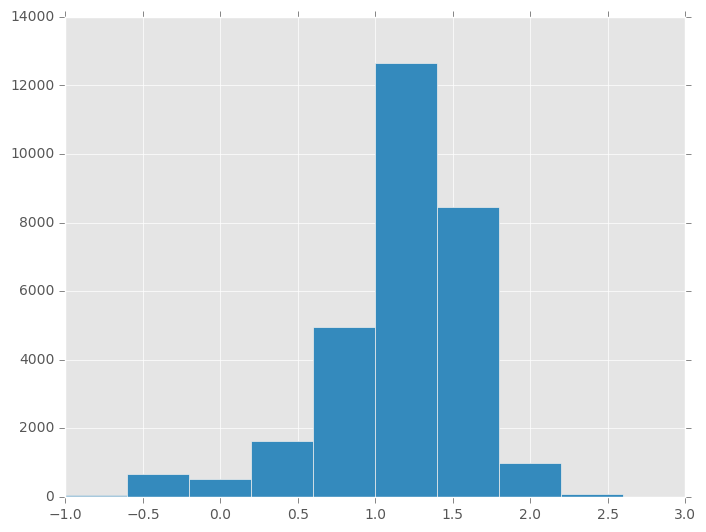

In [28]:
pt = 1
tube = 1

data = np.genfromtxt('C:\\python27\\FCS\\' + str((pt-1)*8+tube) + '.csv',delimiter=',')[1:,4]
#data2 = np.genfromtxt('C:\\python27\\FCS\\' + str((pt-1)*8+tube) + '.csv',delimiter=',')[1:,1]
data = np.log10(data)
#data2 = np.log10(data2)
plt.style.use('ggplot')
plt.plot(1,6)
plt.hist(data,range = [-1,3], bins =10)
plt.show()

Vs patient 9 (leukemic)

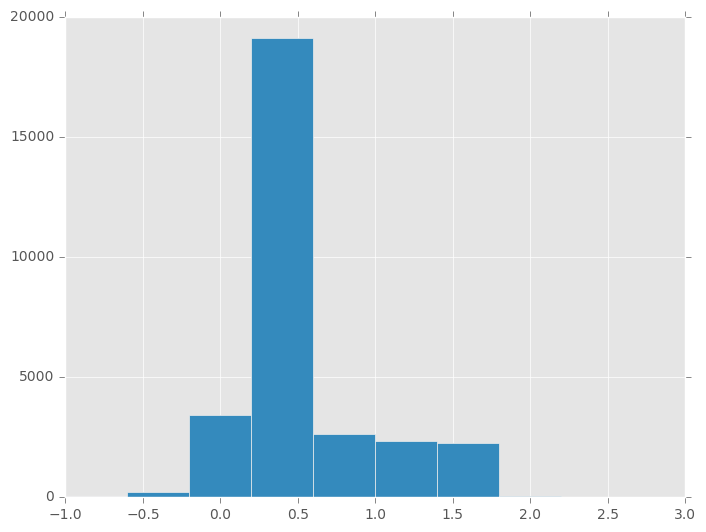

In [27]:
pt = 9
tube = 1

data = np.genfromtxt('C:\\python27\\FCS\\' + str((pt-1)*8+tube) + '.csv',delimiter=',')[1:,4]
data = np.log10(data)
plt.style.use('ggplot')
plt.plot(1,6)
plt.hist(data,range = [-1,3], bins =10)
plt.show()

Can already tell the difference. We will use 10 bin histograms for now as I want to examine up to 7-d space later and I will quickly run out of memory the more bins I use since the data space becomes n_bins^7 large. 

I will go ahead and transform all my data into log 10 transformed and labeled as bins now. FSC (marker 1) in each tube appears to not need the same log trans as the other 6.

In [ ]:
def get_binFSC(x): # for FSC
    return int(x / 205 * 10) # return the tenth (histogram bin) that the data point falls into

def get_binOther(x): # for all others
    return int((np.log10(x)+1) / (3.00645+1) * 10) # return the tenth (histogram bin) that the data point falls into
    # original range after log was -1 to 3.00645 hence the +1 

def binmap(df):
    for i in range(7):
        if i == 0:
            df.ix[:,i] = df.ix[:,[i]].applymap(get_binFSC)
        else: 
            df.ix[:,i] = df.ix[:,[i]].applymap(get_binOther)
            
for i in range(1,2873): 
    temp = pd.read_csv('C:\\python27\\FCS\\'+str(i)+'.csv')
    binmap(temp)
    topath = 'C:\\python27\\FCSlog10\\'+str(i)+'.csv'
    temp.to_csv(topath)

Another peek after log trans and binning

In [30]:
pd.read_csv('C:\\python27\\FCSlog10\\1.csv', index_col = 0).head()

,FS Lin:FS Lin,SS Log:SS Log,FL1 Log:IgG1-FITC,FL2 Log:IgG1-PE,FL3 Log:CD45-ECD,FL4 Log:IgG1-PC5,FL5 Log:IgG1-PC7
0,4,3,0,1,6,0,0
1,9,6,2,1,5,0,0
2,8,5,1,2,5,1,1
3,8,5,1,1,5,0,0
4,8,6,1,1,4,0,0


Curious what the histogram for one of these columns looks like.

In [3]:
temp = np.genfromtxt('C:\\python27\\FCSlog10\\1.csv',delimiter=',',usecols = range(1,8))[1:,:]
print np.histogram(temp[:,2],range = (0,10))[0].tolist()

[9486L, 14711L, 5269L, 440L, 78L, 12L, 2L, 1L, 1L, 0L]


So column 3 (0 indexing) has lots of bins in the 10-20th percentile range. 

Let's create a data matrix.

In [52]:
def get_csv(ptnum,tube,markers):
    """grab a csv in np array"""
    fcs = 'C:\\python27\\FCSlog10\\' + str(8*(ptnum-1)+tube) + '.csv'
    return np.genfromtxt(fcs, delimiter=',',usecols=markers).astype(int)[1:]

def histo(data):
    """
    Input array of cells x markers. Marker levels must already be converted to bin numbers, 
    i.e. signal of 815 of max 1000 is bin 8.
    For each cell, the bin numbers are combined into a combination specific to the n-dimensional
    hypercube in the n-dimensional data space. 
    i.e. Cell #415 has signal 457 for SSC and 180 for CD15. If we are only considering those 2
    markers, the 'index' for the 2-d histogram bin is '4,1'. 
    Defaultdict functions as a counter, incrementing for the appropriate bin index for every 
    cell in the array.    
    """
    
    d = defaultdict(int) 
    for cell in data:
        d[cell] += 1
    return d

def get_combo(tube,markers):
    """
    Input a given tube and set of markers to consider. 
    Calls histo() for every patient and adds the result as a new row in a df. 
    Returns 359 row df. Columns represent bin indexes. Data is counts of cells falling in those bins.
    """
    
    start = time.time()
    combo_hist = pd.DataFrame(histo(get_csv(1,tube,markers)),index=[0])
    
    for ptnum in range(2,360):
        combo_hist.ix[ptnum-1,:] = histo(get_csv(ptnum,tube,markers))

    print('combo complete - ' + str((time.time()-start)/60) + 'min')
    return combo_hist

get_combo(1,3)

combo complete - 0.534833335876min


,0,1,2,3,4,5,6,7,8
0,9486.0,14711.0,5269.0,440.0,78.0,12.0,2.0,1.0,1.0
1,10317.0,2220.0,4423.0,12836.0,176.0,19.0,6.0,3.0,NaN
2,2872.0,5164.0,19635.0,2224.0,69.0,22.0,8.0,2.0,1.0
3,5119.0,13085.0,10337.0,1308.0,106.0,24.0,10.0,4.0,4.0
4,4403.0,2473.0,11404.0,11202.0,500.0,9.0,8.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...
354,5295.0,3527.0,17438.0,3524.0,171.0,29.0,8.0,5.0,3.0
355,2967.0,10961.0,15139.0,872.0,38.0,13.0,4.0,2.0,2.0
356,14252.0,2361.0,2724.0,2726.0,2965.0,2263.0,667.0,35.0,10.0
357,9434.0,11790.0,8037.0,490.0,35.0,6.0,4.0,NaN,NaN


That matrix contains 359 histograms for marker 3 in tube 1. We can combine histograms for all 7 markers side by side to feed it through the SVM. We'll also have to scale it to -1 to 1 or 0 to 1 (it doesn't matter). Also the scaler can't handle NaN so we have to backfill with 0s.

In [55]:
def scale_data(data):
    """
    MinMaxScaler normalizes data to 0-1. -1 to 1 may also be used interchangeably.
    """
    
    scale = MinMaxScaler()
    #scale = MaxAbsScaler()
    data = scale.fit_transform(data)
    #data = data[:,data.sum(axis=0)!=0] # drop 100% empty columns
    return data

def all_combos(tube):
    """
    Input tube to consider.
    For every combination of markers (however many markers at a time we are considering),
    call tube_data() to get histo data for all cells for every patient for that combo.
    Iterate for every combo of markers and concat.
    Output is 359 patients x nCr dfs concat'ed horizontally, where m_columns in those 
    dfs depends on how many bins actually had cells (no cells in the bin for all 
    patients = not added to df).
    """
    
    start = time.time()
    firstcombo = True
    tube_data = pd.DataFrame()
    for markers in range(1,8):
        if firstcombo == True:
            tube_data = get_combo(tube,markers)
            firstcombo = False
        else:
            tube_data = pd.concat([tube_data, get_combo(tube,markers)],axis = 1)
    tube_data = scale_data(tube_data.fillna(0))
    
    print('tube complete - ' + str((time.time()-start)/60) + 'min')
    return tube_data

scaled_data = all_combos(1)

combo complete - 0.540083332856min
combo complete - 0.538050003846min
combo complete - 0.538416667779min
combo complete - 0.539749999841min
combo complete - 0.536500000954min
combo complete - 0.544483335813min
combo complete - 0.540833334128min
tube complete - 3.77823333343min


Alright! let's see what the SVM has to say about predicting some labels. See the attached document for more in depth explanations of why SVM and how to avoid overfitting, etc. Suffice to say, I use sklearn's gridsearch to find the most appropriate regularization term. I am using 5-fold cross validation.

In [56]:
def gridsearch(X,Y,algorithm,params,cv,scoring):
    """
    Grid search iterator for finding C.
    Input data, labels, algo (SVM), range of C to test, CV method, scoring method)
    Output result grid
    """
    
    #start = time.time()
    grid = model_selection.GridSearchCV(algorithm, param_grid=params, cv=cv, scoring = scoring)
    grid.fit(X,Y)
    #print 'gridsearch: ' + str((time.time()-start)/60) + 'min'
    return pd.DataFrame(grid.cv_results_)

def split_and_fit(data):
    """
    Create preds from tube data generated from all_tubes().
    Input data from all_tubes(). 
    Create test folds of 72 (5 folds total). 
    For training 80% of data, run gridsearch and select C that produces highest test score.
    Use that C to predict on test fold.
    Repeat for remaining folds.  Add predictions to end of list of previous fold(s).
    Return 359 predictions.    
    """
    
    start = time.time()
    Y = pd.read_csv('C:\\python27\\CAPSTONE\\Y.csv')
    
    #Y = Y.drop(339,axis = 0).reset_index(drop = True)
    #data = np.delete(data,339,0)
    
    predictions = list()
    
    step = 72
    ptlist = range(0,Y.shape[0])[::step]
    
    for pt in ptlist:

        if pt == 180:
            print('pt 180 complete')
        
        try:
            XTRAIN, XTEST = np.delete(data, range(pt,pt+step), 0), data[pt:pt+step]
            YTRAIN = Y.drop(range(pt,pt+step),axis = 0).as_matrix().reshape(Y.shape[0]-step,)
        except ValueError: 
            print pt
            XTRAIN, XTEST = np.delete(data, range(pt,Y.shape[0]), 0), data[pt:Y.shape[0]]
            YTRAIN = Y.drop(range(pt,Y.shape[0]),axis = 0).as_matrix().reshape(pt,)
        
        hiC = 6
        lowC = -6
        
        f1_scorer = metrics.make_scorer(metrics.f1_score, labels=['aml','normal'], pos_label='aml')
        algorithm, params, scoring = svm.LinearSVC(), {'C': np.logspace(lowC, hiC, hiC-lowC+1, endpoint=True)}, f1_scorer
        cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
        results = gridsearch(XTRAIN, YTRAIN, algorithm, params, cv, scoring)
        
        #gamma = results.ix[results['mean_test_score'].idxmax(),5]
        C = results.ix[results['mean_test_score'].idxmax(),4]
        #if (C==10**hiC)|(C==10**lowC):
        print C
                
        linSVC = svm.LinearSVC(C = C)
        linSVC.fit(XTRAIN,YTRAIN)
        predictions.extend(linSVC.predict(XTEST))
        #predictions.extend(list(logREG.predict_proba(XTEST)[:,0]))
    print 'split_and_fit: ' + str((time.time()-start)/60) + 'min'
    return predictions

preds = split_and_fit(scaled_data)

C:\Users\Phantom77anto\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1.0
0.1
1.0
1.0
288
1.0
split_and_fit: 0.0646500031153min


Here's a more in depth demonstration of how C is chosen. For example, take the input matrix for tube 1 we have loaded.

In [68]:
XTRAIN = scaled_data
YTRAIN = pd.read_csv('C:\\python27\\CAPSTONE\\Y.csv')
hiC = 6
lowC = -6
        
f1_scorer = metrics.make_scorer(metrics.f1_score, labels=['aml','normal'], pos_label='aml')
algorithm, params, scoring = svm.LinearSVC(), {'C': np.logspace(lowC, hiC, hiC-lowC+1, endpoint=True)}, f1_scorer
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
results = gridsearch(XTRAIN, YTRAIN, algorithm, params, cv, scoring)[range(2,5)]

pd.options.display.max_rows = 14
results

,mean_test_score,mean_train_score,param_C
0,0.000000,0.000000,1e-06
1,0.000000,0.000000,1e-05
2,0.000000,0.000000,0.0001
3,0.000000,0.000000,0.001
4,0.116364,0.169972,0.01
5,0.819755,0.863265,0.1
6,0.888849,0.949036,1
7,0.820918,0.960040,10
8,0.733276,0.962267,100
9,0.712408,0.954556,1000


We have used sklearn's gridsearch to brute force over a log space of several values of C to find an appropriate value. You may point out that C is actually continuous and we may narrow our search, and that is true, however usually it only makes a miniscule difference in test score. Even if we exhaustively searched for this example, it may only be 1-2% better than what was found already so for time and computing power's sake the parameter search was restricted to powers of 10.

Plotting these values.. red line is test score and blue line is train score. The code is programmed to ignore the perfect 1.0 possible by overfitting to the train score and use the more realistic and generalizable peak test score located at 10^0 or 1.

([<matplotlib.axis.XTick at 0xed2e6a0>,
 <a list of 13 Text xticklabel objects>)

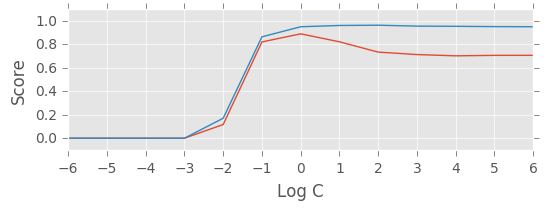

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.figure(1)
plt.subplot(211)
plt.plot(np.log10(results.ix[:,2].tolist()),results[[0]])
plt.plot(np.log10(results.ix[:,2].tolist()),results[[1]])
plt.ylim(-.1,1.1)
plt.ylabel('Score')
plt.xlabel('Log C')
plt.xticks(range(-6,7))

Moving on, now that we have some predictions we will score using f-score (more appropriate for lopsided ratios than straight accuracy)... 

In [57]:
def f1(YPRED):
    """
    f1 function = 2 * harmonic mean of recall and precision.
    Input list of preds.
    Compare with gold standard labels.
    Output f1, recall, precision, TP, FP, FN
    """
    
    Y = pd.read_csv('C:\\python27\\CAPSTONE\\Y.csv')
    YTEST = Y['Condition'].tolist()
    TP, FN, FP = 0., 0., 0.
    for i in range(0,len(YTEST)):
        if (YTEST[i] == 'aml') and (YPRED[i]=='aml'):
            TP += 1
        if (YTEST[i] == 'aml') and (YPRED[i]=='normal'):    
            FN += 1
        if (YTEST[i] == 'normal') and (YPRED[i]=='aml'):
            FP += 1
    try: 
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        f1 = 2 * (recall * precision) / (recall + precision)
    except ZeroDivisionError:
        return 0
        
    return f1, recall, precision, TP, FP, FN

f1(preds)

(0.9268292682926831, 0.8837209302325582, 0.9743589743589743, 38.0, 1.0, 5.0)

Not bad. We can construct an ensemble algorithm of sorts by combining predictions from 7 tubes. Any positive tube should be called overall positive. 

In [ ]:
def pred_map():
    """
    Create 359 x 8 map. First column is true label for all patients (gold standard). 
    Remaining columns are preds corresponding to 1 tube per column.
    Also return a separate master list of preds based on this map where if any one tube was 
    called positive, the master pred was positive.
    """
    
    master = pd.read_csv('C:\\python27\\CAPSTONE\\Y.csv')
    
    for tube in range(1,8):
        data = all_combos(tube)
        master[tube] = split_and_fit(data)
        print('Tube ' + str(tube) + ' complete')
    
    predictions = []
    for i in range(0,359):
        if 'aml' in master[range(1,8)].loc[i].values.tolist():
            predictions.extend(['aml'])
        else: 
            predictions.extend(['normal'])
    return master,predictions

Running f1 again produces:
f1                  sens                PPV                 TP    FP    FN
0.8118811881188119, 0.9534883720930233, 0.7068965517241379, 41.0, 17.0, 2.0

Not bad but we're only looking at 1 marker at a time. Pathologists look at 2. We can make a minor adjustment to our code and run it again... actually we may as well generalize the code to run for any number of markers at once. i.e. for 3 markers at once the histogram bins become cubes, etc. 

The code will combine histograms for all "n choose r" combinations of markers in each tube. 

In [ ]:
def all_combos(tube,n_d):
    """
    Input tube and number of markers to consider.
    For every combination of markers (however many markers at a time we are considering),
    call tube_data() to get histo data for all cells for every patient for that combo.
    Iterate for every combo of markers and concat.
    Output is 359 patients x nCr dfs concat'ed horizontally, where m_columns in those 
    dfs depends on how many bins actually had cells (no cells in the bin for all 
    patients = not added to df).
    """    
    
    start = time.time()
    firstcombo = True
    tube_data = pd.DataFrame()
    for markers in combinations(range(1,8),n_d): ### HERE'S THE CHANGE. COMBINATIONS() GENERATES EVERY COMBO IN N CHOOSE R.
        if firstcombo == True:                   ### WHICH GETS PASSED TO GET_CSV TO SELECT THE APPROPRIATE COLUMNS.
            tube_data = get_combo(tube,markers)
            firstcombo = False
        else:
            tube_data = pd.concat([tube_data, get_combo(tube,markers)],axis = 1)
    tube_data = scale_data(tube_data.fillna(0))
    
    print('tube complete - ' + str((time.time()-start)/60) + 'min')
    return tube_data

After running all that data, it produces this chart (it takes hours to train, especially for 3-5 dimensions):

In [61]:
pd.read_csv('C:\\python27\\chart.csv').ix[:6,:12]

,Dimensions,F-score,Recall,Precision,TP,FP,FN,Features,Median C,S.d. of C,Log s.d. Of C,FN cases
0,1.0,0.81,0.95,0.71,41.0,17.0,2.0,72.0,1.0,16.82,1.23,"7, 118"
1,2.0,0.85,0.95,0.76,41.0,13.0,2.0,1295.0,10.0,21.18,1.33,"7, 118"
2,3.0,0.89,0.95,0.84,41.0,8.0,2.0,9188.0,10.0,0,0.00,"7, 118"
3,4.0,0.96,0.95,0.97,41.0,1.0,2.0,25519.0,10.0,0,0.00,"7, 118"
4,5.0,0.96,0.93,1.00,40.0,0.0,3.0,32384.0,10.0,0,0.00,"7, 101, 118"
5,6.0,0.95,0.95,0.95,41.0,2.0,2.0,19158.0,10.0,0,0.00,"7, 118"
6,7.0,0.91,0.95,0.87,41.0,6.0,2.0,4294.0,10.0,25.23,1.41,"7, 118"


Lots of information here. Let's graph the metrics first.

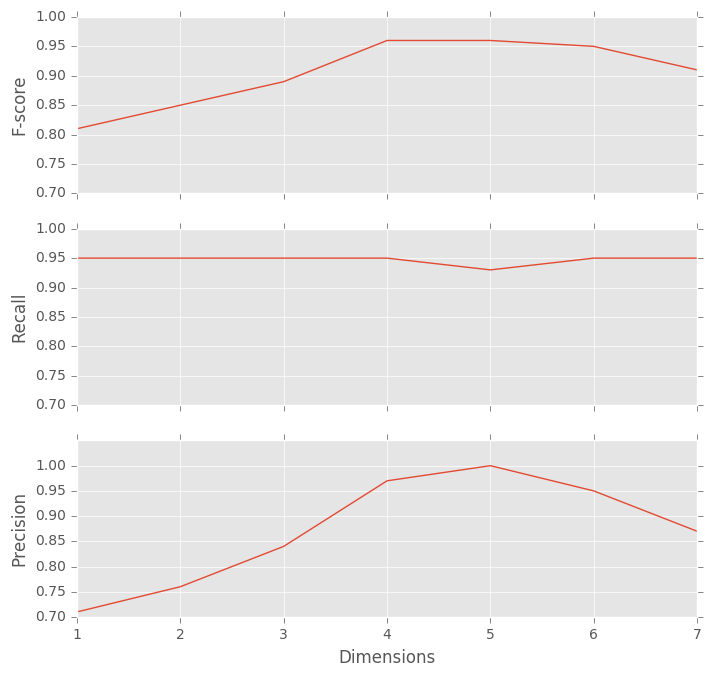

In [63]:
temp = pd.read_csv('C:\\python27\\chart.csv').ix[:6,:12]

plt.style.use('ggplot')

f, axarr = plt.subplots(3,sharex=True)
axarr[0].plot(temp[[0]],temp[[1]])
axarr[1].plot(temp[[0]],temp[[2]])
axarr[2].plot(temp[[0]],temp[[3]])
plt.yticks(np.arange(.7,1.0,.05))

axarr[0].set_xlim(1,7)
axarr[0].set_ylim(.7, 1.0)
axarr[1].set_ylim(.7, 1.0)
axarr[2].set_ylim(.7, 1.05)
plt.yticks(np.arange(.7,1.0,.05))

axarr[0].set_ylabel('F-score')
axarr[1].set_ylabel('Recall')
axarr[2].set_ylabel('Precision')
axarr[2].set_xlabel('Dimensions')
plt.yticks(np.arange(.7,1.0,.05))
f.subplots_adjust(bottom=0)
f.subplots_adjust(top=1)

Not bad! We can clearly see a rise in f-score fueled mainly by precision (PPV), meaning that at first there were lots of false positives. Our model became more and more discerning until it reached a perfect 1.0 in the 5 dimensional hyperspace, and then began declining again. I suspect this has to do with the curse of dimensionality (refer to document for in depth discussion...). 

Also peculiar is the near constant sensitivity that also seems to miss the same two cases every time. There are some inherent weaknesses to this model and these two cases may be getting misclassified; I suspect the main weakness is that the SVM is blind to histogram bin ordering (refer to document), among other weaknesses.

Further investigation is warranted in the future!